### purpose

assign nuisance environmental values to each of the 100 subpopIDs

### outline

the multivariate sims included nuisance envs, but I need to assign env values to each of the individuals from the sim. To do this I match each individual with the nearest climate coordinate. Then given the subpopID I assigned in 02.05.00, create pop means. These means will be used as nuisance env values for both the multivariate sims and the MVP sims.

In [1]:
from pythonimports import *
from myfigs import histo_box

import MVP_summary_functions as mvp

lview, dview = get_client(cluster_id='1681218643-b0yf', profile='lotterhos')

main_outerdir = makedir('/home/b.lind/offsets/nuisance_run_20220919_0-225')

mvp.latest_commit()
session_info.show()

36 36
#########################################################
Today:	April 11, 2023 - 09:13:51
python version: 3.8.5

Current commit of pythonimports:
commit 4ecd56c8c80ec4876790fcd425cb75b9db9a4f24  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 21 13:20:54 2023 -0400

Current commit of MVP_offsets:
commit ef86c4b94658027c580e1bbfdfc1195b0b7077e9  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Mar 23 10:58:00 2023 -0400
#########################################################



# read in individual data

created in 02.05.00_create_files_for_GF_RDA_RONA_then_train_GF.ipynb

In [2]:
inds = pd.read_table('/home/b.lind/offsets/run_20220919_tutorial/tutorial/My_Individuals.txt')

inds.head()

,ind_index,x,y,phenotype1_mat,phenotype2_MTWetQ,phenotype3_MTDQ,phenotype4_PDM,phenotype5_PwarmQ,phenotype6_PWM,env1_mat,env2_MTWetQ,env3_MTDQ,env4_PDM,env5_PwarmQ,env6_PWM,subpopID,lon,lat
0,33,0.406184,0.233272,0.737967,-0.191421,0.142992,-0.131894,-0.452497,-0.541651,0.762432,-0.162238,0.261281,-0.332078,-0.471502,-0.477821,25,5.0,3.0
1,34,0.425697,0.837158,-0.274081,-0.428332,-0.012880,0.221058,0.229296,0.066597,-0.339330,-0.407667,-0.058296,0.288030,0.198810,0.017680,85,5.0,9.0
2,44,0.671673,0.581744,-0.676326,0.086629,-0.470671,0.218813,0.260098,-0.103465,-0.567733,0.090928,-0.414353,0.234899,0.230255,-0.053511,57,7.0,6.0
3,45,0.017466,0.329922,-0.283221,-0.403942,-0.333718,-0.200554,-0.345915,-0.410001,-0.245860,-0.200759,-0.267455,-0.265260,-0.389828,-0.458979,31,1.0,4.0
4,46,0.069744,0.121221,0.057616,-0.303201,0.731600,0.195679,-0.367110,0.196296,-0.121500,-0.306379,0.702858,0.211275,-0.352307,0.212751,11,1.0,2.0


# read in nuisance envs

match nuisance env value with individuals above by finding the nearest point to an individual

In [3]:
# get nuisance envs and their values across the landscape (x/y coords)
nenvs = pd.read_table('/work/lotterhos/MVP-NonClinalAF/multipheno_multienvi/bioclim/nuisance_env.txt',
                      delim_whitespace=True)

# define nuisance environments
nuis_envs = ['ISO', 'TSsd', 'PSsd']

nenvs.head()

,x,y,ISO,TSsd,PSsd,slim_x,slim_y
360,-123.192,53.408,1.047979,1.229545,-0.169714,0.000000,1.0
720,-123.169,53.408,1.047979,1.229545,-0.169714,0.002744,1.0
1080,-123.145,53.408,1.047979,1.244671,-0.093196,0.005607,1.0
1440,-123.122,53.408,1.047979,1.195933,-0.246231,0.008350,1.0
1800,-123.099,53.408,1.047979,1.195933,-0.246231,0.011094,1.0


# retrieve nuisance env values

In [4]:
def euclid(x1, y1, x2, y2):
    """Calculate euclidean distance between (`x1`, `y1`) and (`x2`, `y2`)."""
    import numpy as np
    
    x_sqdiff = (x1 - x2)**2
    y_sqdiff = (y1 - y2)**2
    
    dist_euclid = np.sqrt(x_sqdiff + y_sqdiff)
    
    return dist_euclid

def get_nuis_envs(x, y):
    """Find climate vals for nuisance envs for coordinate closest to (`x`, `y`)."""
    # calculate distance between individual and all climate coordinates
    dist_mat = nenvs[['slim_x', 'slim_y']].apply(lambda x2y2: euclid(x, y, *x2y2), axis=1)
    
    # which climate coordinate has shortest distance to individual?
    climate_coord_idx = dist_mat.sort_values(ascending=True).index[0]
    
    # get climate vals for the nuisance envs at this coordinate
    nuis_vals = nenvs.loc[climate_coord_idx, nuis_envs] 
    
    return nuis_vals
    
dview['nenvs'] = nenvs
dview['euclid'] = euclid
dview['nuis_envs'] = nuis_envs

In [5]:
# give time for objects to upload to engines
sleeping(15)

sleeping: 100%|███████████████| 15/15 [00:15<00:00,  1.00s/it]


In [6]:
# match all 1000 inds to nuisance env values (in parallel)

jobs = []
for ind, (x, y) in inds[['x', 'y']].iterrows():
    
    jobs.append(
        lview.apply_async(
            get_nuis_envs, *(x, y)
        )
    )
    
watch_async(jobs)


Watching 1000 jobs ...


100%|███████████████| 1000/1000 [00:35<00:00, 28.44it/s]


In [7]:
# example output from parallel jobs
jobs[0].r

ISO    -0.120444
TSsd    0.769052
PSsd   -0.552302
Name: 52645, dtype: float64

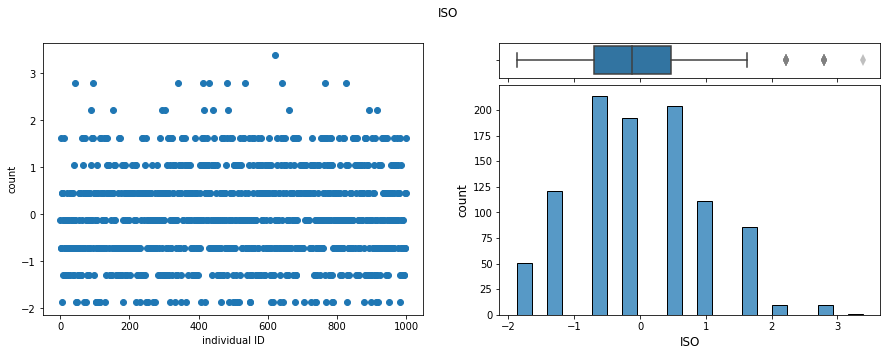

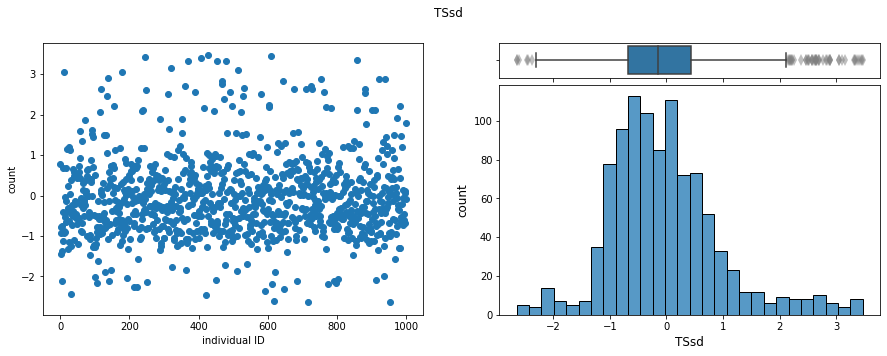

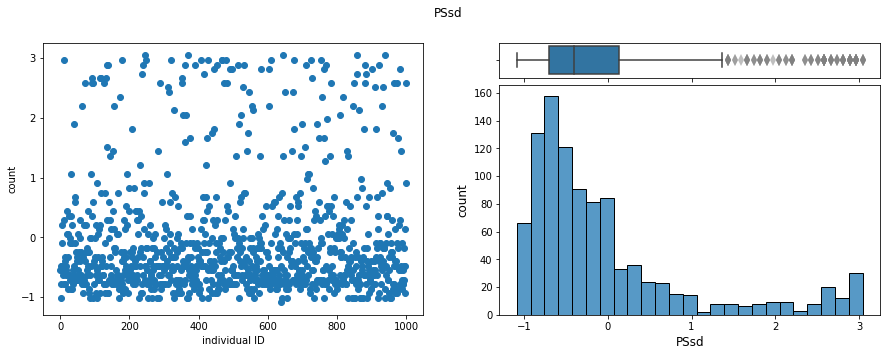

In [8]:
# add columns to individual data
inds[nuis_envs] = np.nan

for ind, j in enumerate(jobs):
    inds.loc[ind, nuis_envs] = j.r
    
for env in nuis_envs:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    ax1.scatter(inds.index, inds[env])
    ax1.set_ylabel('count')  # this should have been `env`
    ax1.set_xlabel('individual ID')
    
    histo_box(inds[env], xlab=env, ylab='count', ax=ax2)
    
    fig.suptitle(env)
    
    plt.show()

# get subpop mean for all nuisance envs

inds assigned subpopIDs in 02.05.00_create_files_for_GF_RDA_RONA_then_train_gf.ipynb

In [17]:
subpop_nuis_vals = inds.groupby('subpopID')[nuis_envs].apply(np.mean)
subpop_nuis_vals.index.name = None

subpop_nuis_vals

,ISO,TSsd,PSsd
1,0.009381,-2.245441,1.003559
2,0.239071,-1.967663,0.518946
3,0.580610,-0.963343,-0.246231
4,0.639031,-0.164371,-0.399267
5,-0.036985,-0.291426,-0.661614
...,...,...,...
96,0.113241,-0.239327,-0.054937
97,0.881061,0.598108,1.480884
98,1.587251,1.669095,2.461321
99,1.381814,2.462649,2.880066


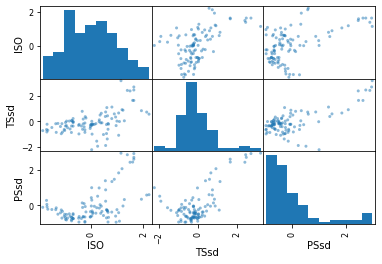

In [10]:
_ = pd.plotting.scatter_matrix(subpop_nuis_vals)

In [19]:
# create 1-env env files
for env in nuis_envs:
    nuisance_file = f'/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_{env}_vals.txt'
    subpop_nuis_vals[env].to_csv(nuisance_file, sep='\t', index=True)
    
    print(nuisance_file)
    
pd.read_table(nuisance_file, index_col=0)

/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_ISO_vals.txt
/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_TSsd_vals.txt
/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_PSsd_vals.txt


,PSsd
1,1.003559
2,0.518946
3,-0.246231
4,-0.399267
5,-0.661614
...,...
96,-0.054937
97,1.480884
98,2.461321
99,2.880066


In [20]:
# create 2-env env files
for i, envi in enumerate(nuis_envs):
    for j, envj in enumerate(nuis_envs):
        if i < j:
            nuisance_file = f'/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_{envi}-{envj}_vals.txt'
            subpop_nuis_vals[[envi, envj]].to_csv(nuisance_file, sep='\t', index=True)
            
            print(nuisance_file)
            
pd.read_table(nuisance_file, index_col=0)

/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_ISO-TSsd_vals.txt
/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_ISO-PSsd_vals.txt
/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_TSsd-PSsd_vals.txt


,TSsd,PSsd
1,-2.245441,1.003559
2,-1.967663,0.518946
3,-0.963343,-0.246231
4,-0.164371,-0.399267
5,-0.291426,-0.661614
...,...,...
96,-0.239327,-0.054937
97,0.598108,1.480884
98,1.669095,2.461321
99,2.462649,2.880066


In [25]:
# create 3-env env files
envs = '-'.join(nuis_envs)
nuisance_file = f'/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_{envs}_vals.txt'

subpop_nuis_vals.to_csv(nuisance_file, sep='\t', index=True)

nuisance_file

'/home/b.lind/offsets/run_20220919_tutorial/tutorial/nuisance_ISO-TSsd-PSsd_vals.txt'

In [26]:
pd.read_table(nuisance_file, index_col=0)

,ISO,TSsd,PSsd
1,0.009381,-2.245441,1.003559
2,0.239071,-1.967663,0.518946
3,0.580610,-0.963343,-0.246231
4,0.639031,-0.164371,-0.399267
5,-0.036985,-0.291426,-0.661614
...,...,...,...
96,0.113241,-0.239327,-0.054937
97,0.881061,0.598108,1.480884
98,1.587251,1.669095,2.461321
99,1.381814,2.462649,2.880066


In [15]:
# save ind values used to calc pop values
ind_nuis_file = '/home/b.lind/offsets/run_20220919_tutorial/tutorial/My_Individuals_nuis_vals.txt'

inds[nuis_envs].to_csv(ind_nuis_file, sep='\t', index=False)

ind_nuis_file

'/home/b.lind/offsets/run_20220919_tutorial/tutorial/My_Individuals_nuis_vals.txt'